In [38]:
import healpy as hp
import pandas as pd
import numpy as np
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from skimage.io import imshow, imsave
%matplotlib inline

In [2]:
patch = pd.read_csv("/home/rt2122/data/one_patch_p.csv", index_col='index')

In [3]:
print(patch.shape)
patch.head()

(320759, 25)


,id,objID,l,b,gPSFFlux,gPSFFluxErr,gKronFlux,gKronFluxErr,rPSFFlux,rPSFFluxErr,...,iKronFluxErr,zPSFFlux,zPSFFluxErr,zKronFlux,zKronFluxErr,yPSFFlux,yPSFFluxErr,yKronFlux,yKronFluxErr,pix
index,,,,,,,,,,,,,,,,,,,,,
0,0,187672181042172483,108.217485,47.747596,3.556950e-07,4.349380e-07,-999.000000,9.990000e+02,4.430870e-07,5.734870e-07,...,4.428020e-07,0.000004,9.685390e-07,-999.000000,999.000000,1.485010e-06,0.000002,-999.000000,999.000000,2.914554e+10
1,0,187672181283370219,108.204059,47.743701,1.082320e-05,4.329770e-07,0.000017,8.027050e-07,1.626730e-05,5.381050e-07,...,7.285690e-07,0.000020,1.099160e-06,0.000032,0.000002,2.346840e-05,0.000002,0.000032,0.000003,2.914554e+10
2,0,187662181196649123,108.207734,47.746415,1.322120e-06,3.966010e-07,-999.000000,9.990000e+02,4.234680e-07,5.407890e-07,...,4.063610e-07,0.000003,9.760390e-07,-999.000000,999.000000,-8.281200e-07,0.000002,-999.000000,999.000000,2.914554e+10
3,0,187672181215422012,108.208625,47.743965,7.719280e-06,4.263940e-07,0.000009,6.707270e-07,1.342360e-05,6.253580e-07,...,6.421820e-07,0.000020,9.953010e-07,0.000029,0.000002,2.430040e-05,0.000002,0.000032,0.000004,2.914554e+10
4,0,187672181135167904,108.216656,47.741807,1.685010e-06,4.597150e-07,-999.000000,9.990000e+02,3.643300e-06,5.087650e-07,...,1.129350e-06,0.000010,1.009070e-06,0.000013,0.000002,1.387760e-05,0.000002,0.000018,0.000003,2.914551e+10


In [4]:
pix_center = 29146875562

In [5]:
from data_obj import make_pic

In [6]:
pic = make_pic(pix_center, nside=2**17, size=4096)

In [7]:
np.save('pixels.p', pic)

In [6]:
pic = np.load('pixels.p.npy')

In [7]:
pic.shape

(4096, 4096)

In [8]:
def pix2dict(matr):
    ans = {}
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            ans[matr[i, j]] = (i, j)
    return ans

In [47]:
def pic_one_filter_d(f, patch, pix_dict, size=4096, def_val=-1):
    result = np.full((size, size), def_val, dtype=np.float32)
    for i in tqdm_notebook(range(patch.shape[0])):
        filtr = f + 'KronFlux'
        flux = patch[filtr].iloc[i]
        '''
        if flux == -999:
            filtr = f + 'PSFFlux'
            flux = patch[filtr].iloc[i]
        if flux == -999:
            continue
            
        if flux < 0:
            err = patch[filtr + 'Err'].iloc[i]
            if err == 999:
                continue
            flux += err 
            if flux < 0:
                continue
        '''
        if flux == -999:
            continue
            
        pix = patch['pix'].iloc[i]
        if pix in pix_dict:
            x, y = pix_dict[pix]
            result[x, y] = flux
    return result

In [10]:
dict_pic = pix2dict(pic)

In [31]:
gpic = pic_one_filter_d('g', patch, dict_pic)

In [32]:
gpic.min(), gpic.max()

(-4.0, 0.156593)

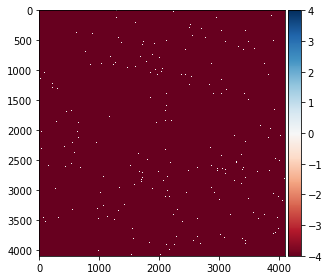

In [34]:
imshow(gpic)

In [35]:
def pic_all_filters(patch, pix_dict):
    ans = []
    for f in ['g', 'r', 'i', 'z', 'y']:
        ans.append(pic_one_filter_d(f, patch, pix_dict))
    return np.dstack(ans)

In [48]:
all_f = pic_all_filters(patch, dict_pic)

In [50]:
all_f = np.clip(all_f, -1, 1)

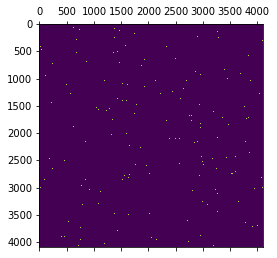

In [51]:
plt.matshow(all_f[:, :, 0])

In [26]:
all_f.min(), all_f.max()

(0.0, 0.799048)

In [41]:
(patch[patch['gKronFlux'] != -999]['gKronFlux'] + patch[patch['gKronFlux'] != -999]['gKronFluxErr'] ** 2).min(),

(-0.0071055530695016906,)

In [67]:
imsave('gri.png', all_f[:1024,:1024,3].astype(np.int32))

In [68]:
imsave('izy.png', all_f[:1024,:1024,2:].astype(np.int32))

/home/rt2122/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int32 to uint8 without scaling because max value 132 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


In [54]:
all_f += 1
all_f /= 2

In [55]:
all_f *= 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


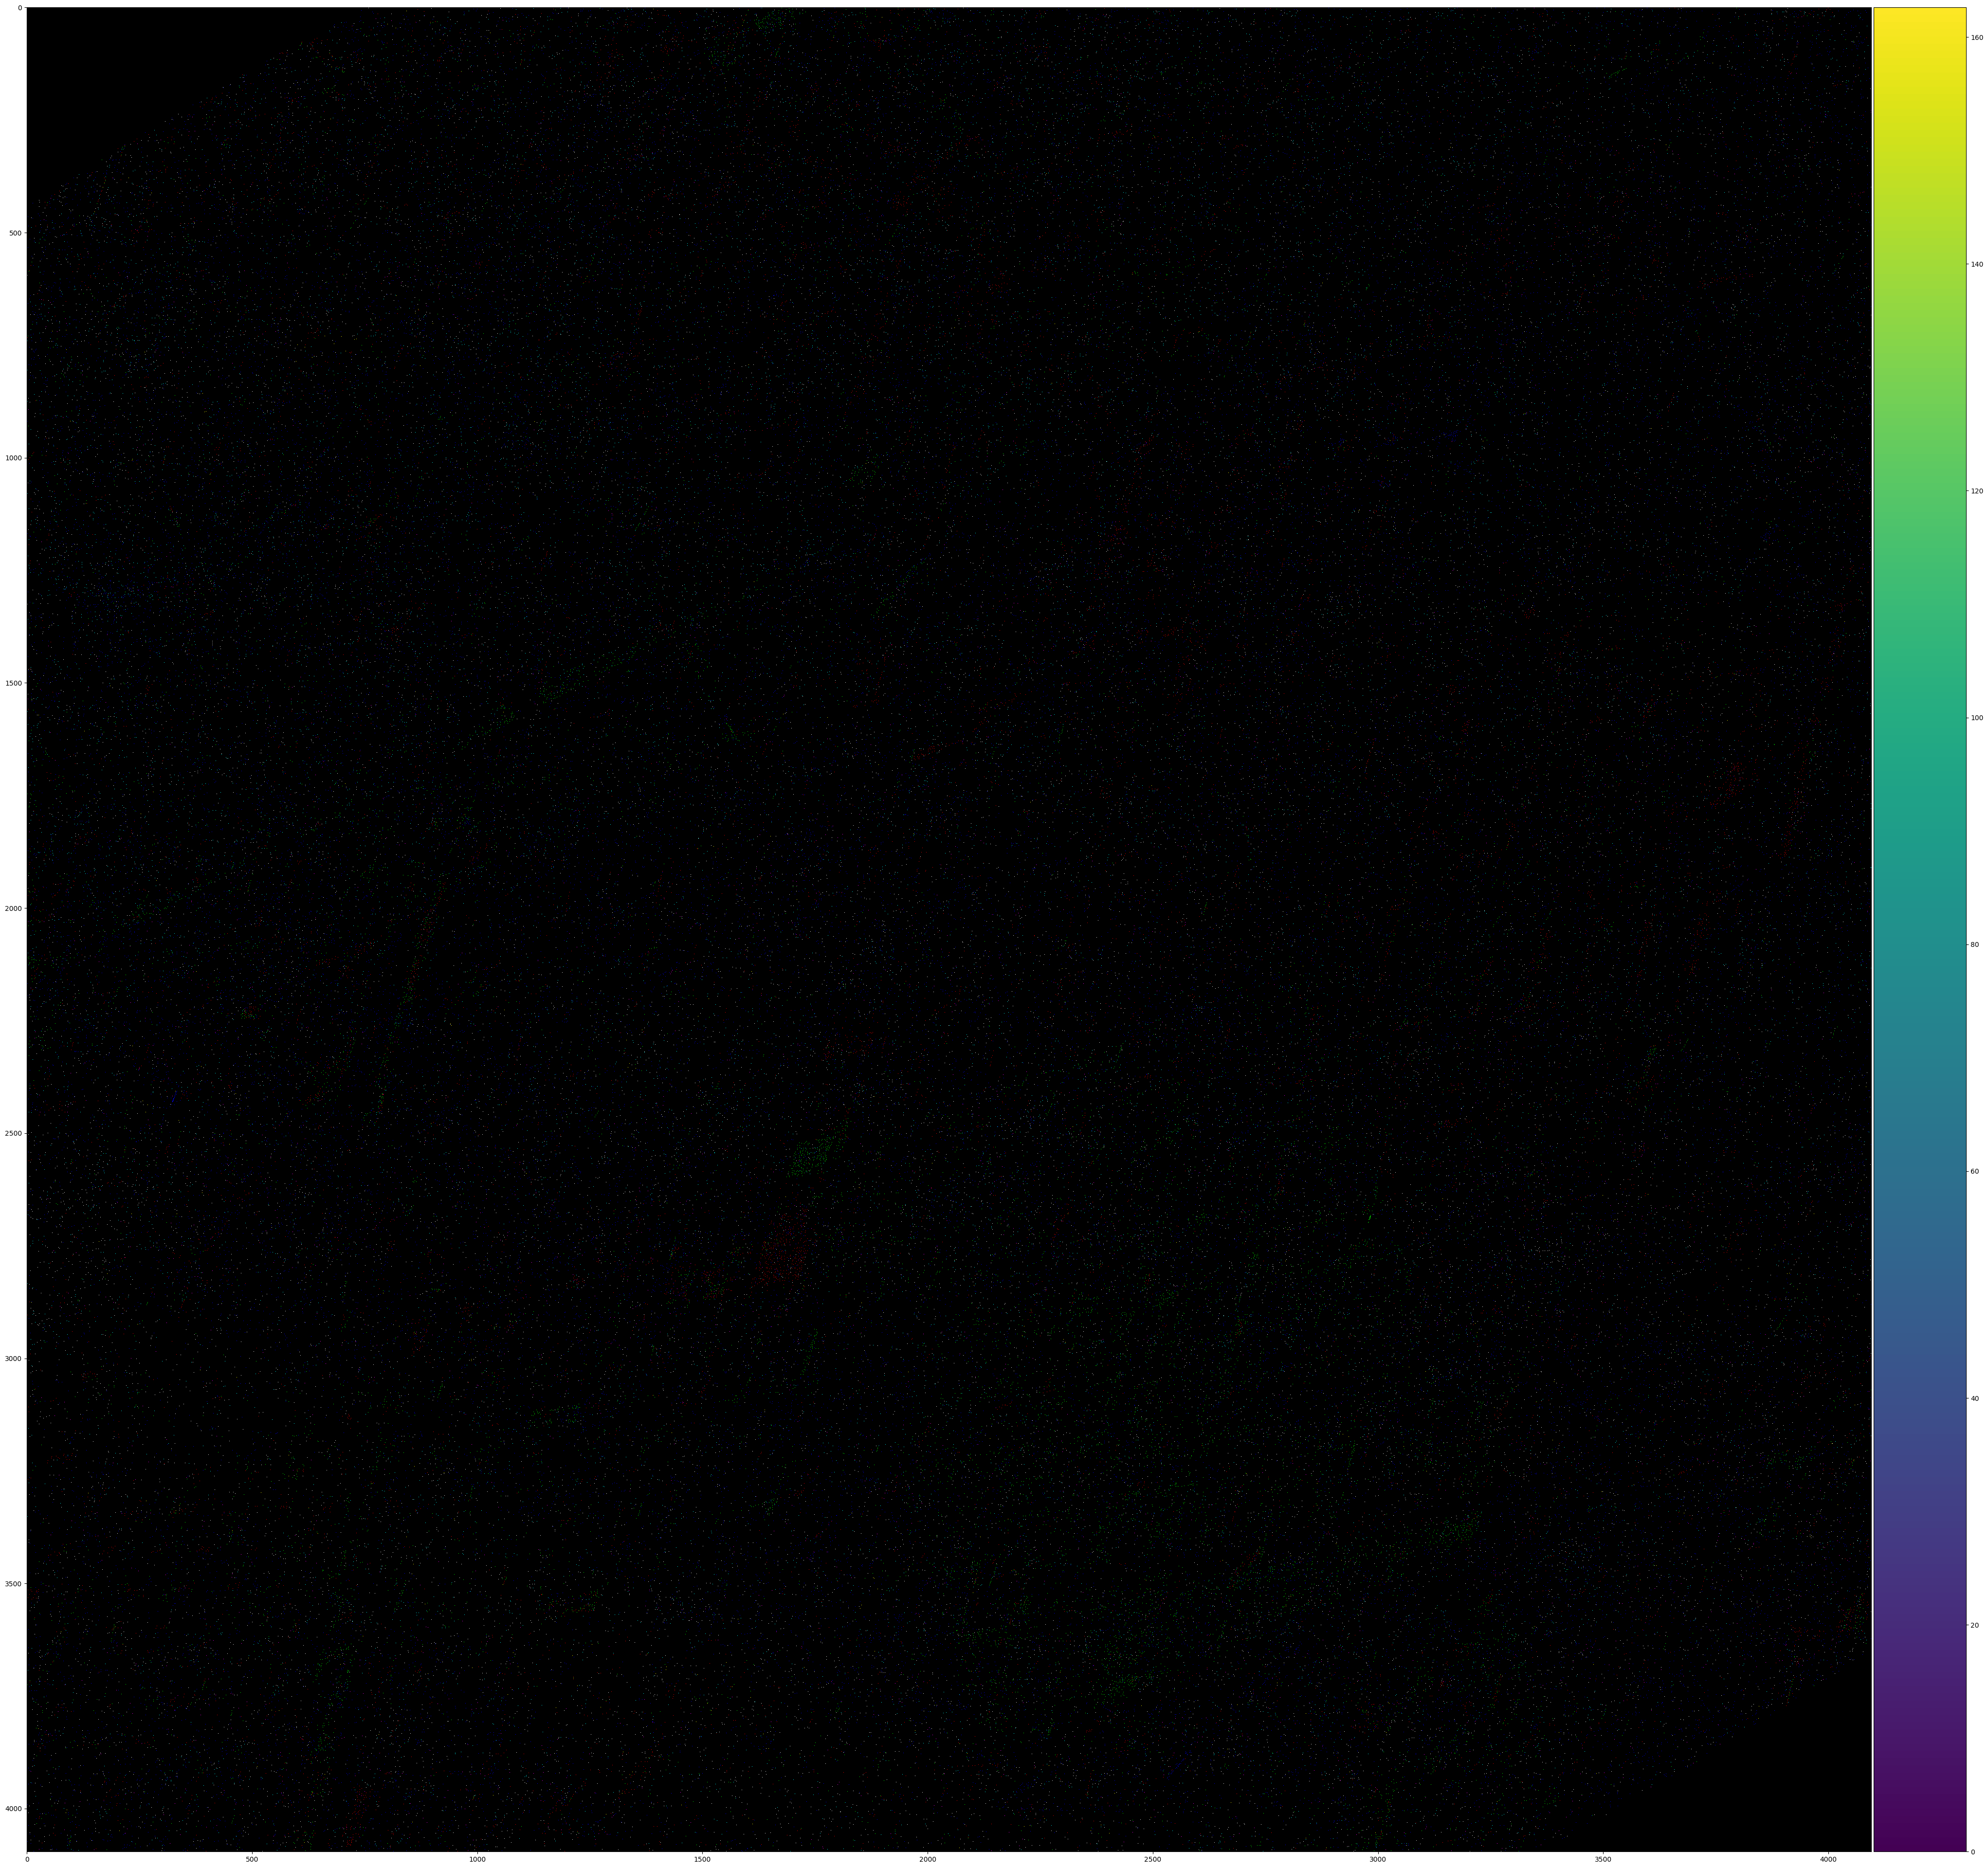

In [66]:
dpi = 100
plt.figure(figsize=(4096 / dpi, 4096 / dpi), dpi=dpi)
imshow(all_f[:,:,:3])

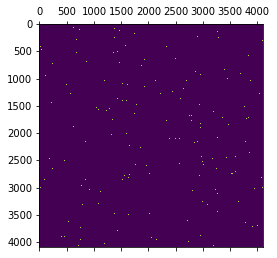

In [60]:
plt.matshow(all_f[:,:,0])

In [69]:
cl, cb = hp.pix2ang(ipix=pix_center, nside=2**17, nest=True, lonlat=True)

In [70]:
l, b = hp.pix2ang(ipix=pic[0,0], nside=2**17, nest=True, lonlat=True)

In [72]:
csc = SkyCoord(l=cl*u.degree, b=cb*u.degree, frame='galactic')
sc = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')

In [73]:
csc.separation(sc).degree

1.6904077232314192